In [1]:
import numpy as np
import cv2 as cv
import os
from segmentation import Segmentation as Segmentation
from background_subtraction_gmm import Backsub as Backsub
from matplotlib import pyplot as plt
from match_particle import match,match_Jaq
from match_particle import erase_short_objects
from match_particle import erase_border_circles


# input parameter

In [2]:
video_path="Video_Data/Gute_aufnahme_shortened.avi"
image_folder="Image_Data/Gute_aufnahme_shortened"
data_folder="data/Gute_aufnahme_shortened"

start_frame=0
stream_string = [os.path.join(image_folder,img) for img in os.listdir(image_folder) if img.endswith(".jpg")]
stream_string.sort()
end_frame=len(stream_string)-1


Create and learn background object and segmentation object

In [3]:
backsub=Backsub(video_path,history=100)
number_training_images=450
backsub.begin_train(max_frames=number_training_images)
segm=Segmentation(backsub)

# Check on first image

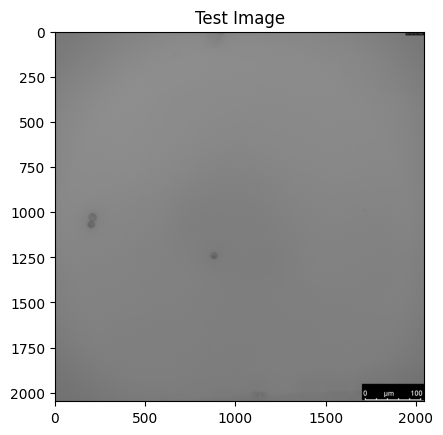

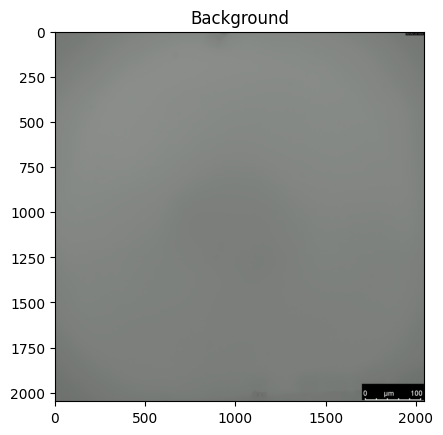

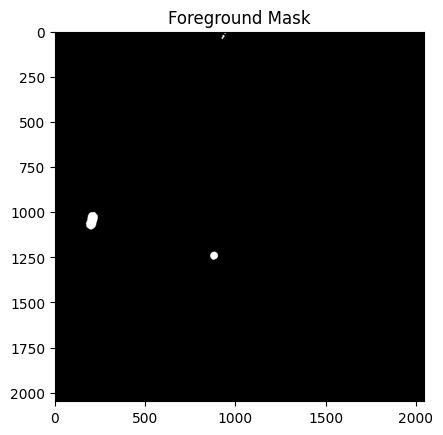

In [4]:
test_image=cv.imread(stream_string[0], cv.IMREAD_COLOR)
plt.figure()
plt.imshow(test_image,cmap="gray")
plt.title("Test Image")
b=backsub.getBackgroundImage()
plt.figure()
plt.imshow(b,cmap="gray")
plt.title("Background")

m=backsub.getMask(test_image)
plt.figure()
plt.imshow(m,cmap="gray")
plt.title("Foreground Mask")
plt.show()


None


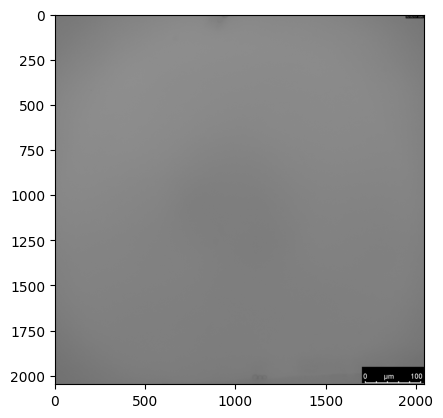

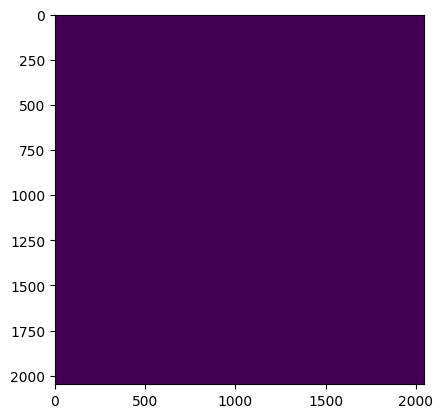

In [5]:
src=cv.imread(stream_string[800], cv.IMREAD_COLOR)
plt.figure()
plt.imshow(src)
plt.figure()
m=backsub.getMask(src)
plt.imshow(m)
c=segm.segment_image(src,canny_upper=40)
print(c)

Save all object data in array

In [6]:
circles_stream=[None]*(end_frame-start_frame+1)
for j,img in enumerate(stream_string):
    try:
        src=cv.imread(img, cv.IMREAD_COLOR)
        if j>number_training_images:
            segm.backsub.train_on_image(src)
        circles_stream[j]=segm.segment_image(src,canny_upper=30,minradius=14,maxradius=25)
    except:
        print("Error in iteration and image_name:",j,img)
    
height, width=src.shape[:2]
    



In [7]:
# set frames per second
fps=15


video = cv.VideoWriter(os.path.join("Video_Data/Gute_aufnahme_shortened","segmentation.avi"), 0, fps, (height,width) ,isColor=True)
# for writing on image
font = cv.FONT_HERSHEY_SIMPLEX
org = (20, 25)
fontScale = 1
color = (255, 0, 0)
thickness = 1
k=0


for j,img in enumerate(stream_string):
    src=cv.imread(img, cv.IMREAD_COLOR)
    if circles_stream[j] is not None:
        for circle in circles_stream[j]:
            cv.circle(src, (round(circle[0]),round(circle[1])), round(circle[2]), color=(255, 0, 0) , thickness=3) 
    video.write(src)
cv.destroyAllWindows()
video.release()

In [8]:
circles_stream=erase_border_circles(circles_stream, width=width, height=height)
matched_objects=match(circles_stream, frame_numb_offset=start_frame, eps1=250)
#matched_objects=match_Jaq(circles_stream, frame_numb_offset=start_frame, eps1=150)
matched_objects=erase_short_objects(matched_objects,min_num_frames=20)

In [9]:
for i in range(len(matched_objects)):
    print(i,matched_objects[i][-1,:])
    print(matched_objects[i].shape)
    if matched_objects[i].shape[0]-int(matched_objects[i][-1,0]+1-matched_objects[i][0,0])!=0:
        print("object: "+str(i)+" has not been matched correctly please check background and segmentation variables!")

0 [  99.         1945.5        1181.5          19.89999962]
(100, 4)
1 [ 132.  2017.5  939.5   21. ]
(133, 4)
2 [  93.          471.5        1054.5          20.20000076]
(94, 4)
3 [ 190.  1972.5   70.5   18.5]
(93, 4)
4 [ 128.         1520.5        1004.5          17.70000076]
(30, 4)
5 [130.  328.5  22.5  18. ]
(32, 4)
6 [ 230.  2004.5 1573.5   20.5]
(99, 4)
7 [ 319.         1600.5        1254.5          18.29999924]
(61, 4)
8 [ 350.         1241.5         457.5          20.70000076]
(30, 4)
9 [ 346.         2026.5        1234.5          18.29999924]
(25, 4)
10 [ 453.  2021.5  637.5   18. ]
(49, 4)
11 [ 687.         2006.5        1350.5          20.20000076]
(101, 4)
12 [ 966.         2020.5         761.5          17.20000076]
(90, 4)
13 [ 996.  2006.5  315.5   18.5]
(79, 4)
14 [1066.  2018.5  251.5   21. ]
(68, 4)


# save segmented object and corresponding stream string

In [10]:
os.makedirs(data_folder,exist_ok=True)
np.save(os.path.join(data_folder,"image_paths.npy"),stream_string)
for i in range(len(matched_objects)):
    np.save(os.path.join(data_folder,"pos_data")+"_"+str(i)+".npy",matched_objects[i])


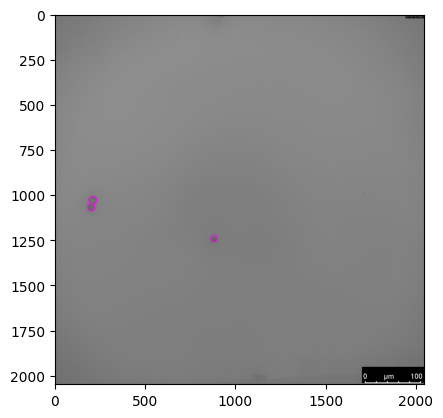

In [11]:
src=cv.imread(stream_string[int(matched_objects[0][0,0])], cv.IMREAD_COLOR)
circles=segm.segment_image(src,canny_upper=40)
for i in range(circles.shape[0]):
    center = (round(circles[i,0]), round(circles[i,1]))
    # circle outline
    radius = round(circles[i,2])
    # circle center
    cv.circle(src, center, radius, (255, 0, 255), 3)
fig=plt.figure()
plt.imshow(src)
plt.show()


(slice(1219, 1266, None), slice(857, 904, None))
[   0.   879.5 1242.5   18. ]


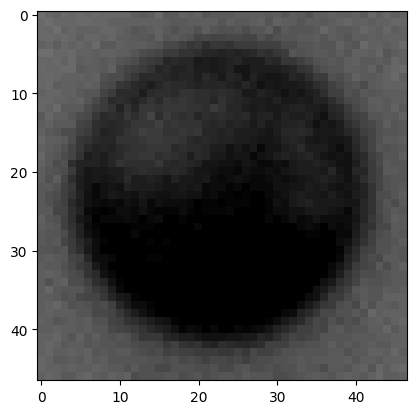

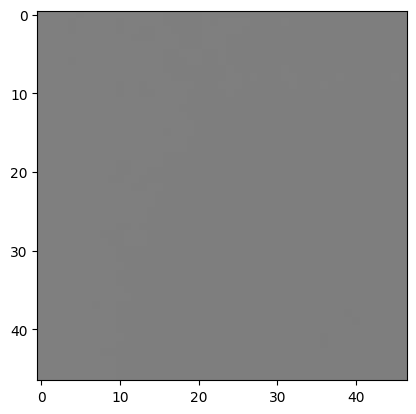

In [12]:
src=cv.imread(stream_string[int(matched_objects[0][0,0])], cv.IMREAD_COLOR)
gray=np.float64(cv.cvtColor(src, cv.COLOR_BGR2GRAY))
obj=matched_objects[0][0,:]
index=np.s_[round(obj[2])-round(obj[3]+5):round(obj[2])+round(obj[3]+5)+1,round(obj[1])-round(obj[3]+5):round(obj[1])+round(obj[3]+5)+1]
print(index)
gray=gray[index]
background_gray=np.float64(cv.cvtColor(backsub.getBackgroundImage(),cv.COLOR_BGR2GRAY))
background_gray=background_gray[index]
image=gray-background_gray

slic=[]
print(matched_objects[0][0,:])
plt.figure()
plt.imshow(gray,cmap="gray",vmin=100,vmax=160)
plt.show()
plt.figure()
plt.imshow(background_gray,cmap="gray",vmin=0,vmax=255)
plt.show()

